## Simple example & Sanity check

Below, a simple example for the use of B-CNN is presented

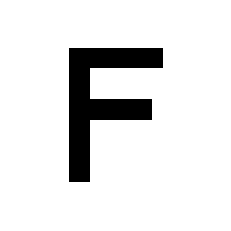

In [3]:
import numpy as np
import matplotlib.pyplot as plt

image_res = 21
radius = image_res // 2

ini_im = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],]

ini_im = np.abs(np.array(ini_im)-1)
mask_pos = np.zeros((image_res, image_res))
for i in range(image_res):
    for j in range(image_res):
        if np.sqrt((i-radius)**2 + (j-radius)**2) > radius:
            mask_pos[i,j] = 1.
mask_neg = np.abs((mask_pos - 1))
            
plt.imshow(ini_im*mask_neg+mask_pos, cmap='gray', vmin=0.0, vmax=1.0)
plt.axis(False);

Then, the image is also rotated, to check the rotation invariance of B-CNNs

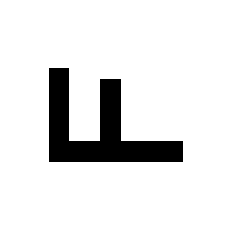

In [5]:
from imutils import rotate

new_im = rotate(ini_im.astype(np.double), 90)
plt.imshow(new_im*mask_neg+mask_pos, cmap='gray', vmin=0.0, vmax=1.0)
plt.axis(False);

In [20]:
from sys import path
path.append('../codes')
from BesselConv2d import BesselConv2d

import tensorflow as tf
from tensorflow import keras

In [17]:
model = keras.models.Sequential()

k = 11 ; n_filters = 1
model.add(BesselConv2d(k=k, C_out=n_filters, reflex_inv=False, scale_inv=False, strides=1, 
                       padding='VALID', activation=None, input_shape=(21,21,1)))
model.build(input_shape=(None, 21, 21, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bessel_conv2d (BesselConv2d  (None, 11, 11, 1)        257       
 )                                                               
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


Due to the use of $k_{max}$ that truncates the weight matrix, the number of trainable params retrieved by keras is over-estimated. The true number of trainable parameters can be retrieved by doing...

In [19]:
print(model.layers[0].n_params)

83


In [25]:
inputs = tf.concat([ini_im[None,:,:,None], new_im[None,:,:,None]], axis=0)

In [26]:
outputs = model.predict(inputs)

1/1 [==============================] - 10s 10s/step


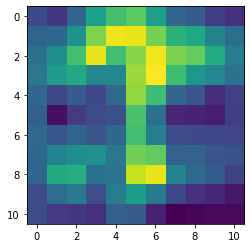

In [27]:
plt.imshow(outputs[0,:,:,0])

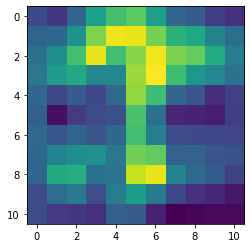

In [28]:
plt.imshow(rotate(outputs[1,:,:,0], -90))

## A more elaborated example

In this example, we will train an SO(2)+ B-CNNs model on MNIST. We will also use the TensorCore units to speed up computations.
To do so, the TensorCorePad meta-parameter should be set to True, and the inputs should be in half-precision.

In [29]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [31]:
batch_size = 64

data_augmentation = keras.Sequential([
    keras.layers.RandomRotation(1.0),
])

train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float16), y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

test_dataset = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float16), y_test))
test_dataset = test_dataset.batch(batch_size)

In [32]:
model = tf.keras.models.Sequential()

# Block 1
k = 9 ; n_filters = 8
model.add(BesselConv2d(k=k, C_out=n_filters, strides=1, padding='SAME', scales=[-2,0,2], 
                       activation=None, name='Bessel_1', reflex_inv=False, TensorCorePad=True))
model.add(tf.keras.layers.Activation(tf.keras.activations.softsign))
k = 7 ; n_filters = 16
model.add(BesselConv2d(k=k, C_out=n_filters, strides=1, padding='SAME', scales=[-2,0,2], 
                       activation=None, name='Bessel_2', reflex_inv=False, TensorCorePad=True))
model.add(tf.keras.layers.Activation(tf.keras.activations.softsign))

model.add(tf.keras.layers.AveragePooling2D((2, 2)))

# Block 2
k = 7 ; n_filters = 24
model.add(BesselConv2d(k=k, C_out=n_filters, strides=1, padding='SAME', scales=[-2,0,2], 
                       activation=None, name='Bessel_3', reflex_inv=False, TensorCorePad=True))
model.add(tf.keras.layers.Activation(tf.keras.activations.softsign))
k = 7 ; n_filters = 24
model.add(BesselConv2d(k=k, C_out=n_filters, strides=1, padding='SAME', scales=[-2,0,2], 
                       activation=None, name='Bessel_4', reflex_inv=False, TensorCorePad=True))
model.add(tf.keras.layers.Activation(tf.keras.activations.softsign))

model.add(tf.keras.layers.AveragePooling2D((2, 2)))

# Block 3
k = 7 ; n_filters = 32
model.add(BesselConv2d(k=k, C_out=n_filters, strides=1, padding='SAME',
                       activation=None, name='Bessel_5', reflex_inv=False, TensorCorePad=True))
model.add(tf.keras.layers.Activation(tf.keras.activations.softsign))
k = 7 ; n_filters = 40
model.add(BesselConv2d(k=k, C_out=n_filters, strides=1, padding='VALID',
                       activation=None, name='Bessel_6', reflex_inv=False, TensorCorePad=True))
model.add(tf.keras.layers.Activation(tf.keras.activations.softsign))

# Final prediction
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.build(input_shape=(None, 28, 28, 1))

KeyboardInterrupt: 

In [ ]:
n_trainable = 0
for layer in model.layers:
    if 'Bessel' in layer.name:
        n_trainable += layer.n_params
    else:
        n_trainable += count_params(layer.trainable_weights)
        
print('\n\nThe model is made of', n_trainable, 'trainable parameters\n\n')

In [ ]:
# Epochs
epochs = 10

# Optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')

model.compile(optimizer=optimizer, loss=loss_fcn, metrics=metric)

In [ ]:
model.fit(train_dataset,
          validation_data = test_dataset,
          epochs=epochs)